In [55]:
# To start, we install Rasterio, a Python module for interacting with gridded spatial data
!pip install rasterio
!pip install xarray
!pip install dask
!pip install dask-image
!pip install graphviz
!pip install scikit-image
!python -m pip install "dask[distributed]" --upgrade

     |████████████████████████████████| 13.3 MB 7.1 MB/s            
     |████████████████████████████████| 3.3 MB 93.8 MB/s            
     |████████████████████████████████| 178 kB 118.1 MB/s            
     |████████████████████████████████| 15.7 MB 87.8 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.0.13 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.0.1 which is incompatible.
spacy 3.2.1 requires typing-extensions<4.0.0.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.0.1 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.21.5 which is incompatible.


# Image processing

In [56]:
import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
import dask.array as da

### We'll also use matplotlib to display image results in this notebook.

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

## Getting the example data

We'll use some example image data from the scikit-image library in this tutorial. These images are very small, but will allow us to demonstrate the functionality of dask-image. <br>
Let's download and save a public domain image of the astronaut Eileen Collins to a temporary directory. This image was originally downloaded from the NASA Great Images database https://flic.kr/p/r9qvLn, but we'll access it with scikit-image's data.astronaut() method.

In [58]:
!mkdir temp

mkdir: cannot create directory ‘temp’: File exists


In [59]:
import os
from skimage import data, io

output_filename = os.path.join('temp', 'astronaut.png')
io.imsave(output_filename, data.astronaut())

Really large datasets often can't fit all of the data into a single file, so we'll chop this image into four parts and save the image tiles to a second temporary directory. This will give you a better idea of how you can use dask-image on a real dataset.

In [60]:
!mkdir temp-tiles

In [61]:
io.imsave(os.path.join('temp-tiles', 'image-00.png'), data.astronaut()[:256, :256, :])  # top left
io.imsave(os.path.join('temp-tiles', 'image-01.png'), data.astronaut()[:256, 256:, :])  # top right
io.imsave(os.path.join('temp-tiles', 'image-10.png'), data.astronaut()[256:, :256, :])  # bottom left
io.imsave(os.path.join('temp-tiles', 'image-11.png'), data.astronaut()[256:, 256:, :])  # bottom right

Now we have some data saved, let's practise reading in files with dask-image and processing our images.

## Reading in image data

Reading a single image. <br>
Let's load a public domain image of the astronaut Eileen Collins with dask-image imread(). This image was originally downloaded from the NASA Great Images database https://flic.kr/p/r9qvLn.

In [62]:
import os
filename = os.path.join('temp', 'astronaut.png')
print(filename)

temp/astronaut.png


dask.array<_map_read_frame, shape=(1, 512, 512, 3), dtype=float32, chunksize=(1, 512, 512, 3), chunktype=numpy.ndarray>


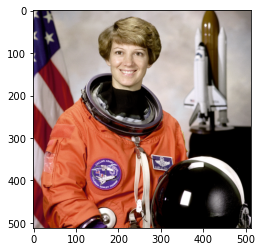

In [63]:
astronaut = dask_image.imread.imread(filename)
print(astronaut)
plt.imshow(astronaut[0, ...])  # display the first (and only) frame of the image

This has created a dask array with shape=(1, 512, 512, 3). This means it contains one image frame with 512 rows, 512 columns, and 3 color channels.
Since the image is relatively small, it fits entirely within one dask-image chunk, with chunksize=(1, 512, 512, 3).

## Reading multiple images

In many cases, you may have multiple images stored on disk, for example: image_00.png, image_01.png, ... image_NN.png. These can be read into a dask array as multiple image frames. <br>

Here we have the astronaut image split into four non-overlapping tiles: <br>

- image_00.png = top left image (index 0,0)
- image_01.png = top right image (index 0,1)
- image_10.png = bottom left image (index 1,0)
- image_11.png = bottom right image (index 1,1)

This filename pattern can be matched with regex: image-*.png

In [64]:
!ls temp-tiles

image-00.png  image-01.png  image-10.png  image-11.png


In [65]:
import os
filename_pattern = os.path.join('temp-tiles', 'image-*.png')
tiled_astronaut_images = dask_image.imread.imread(filename_pattern)
print(tiled_astronaut_images)

dask.array<_map_read_frame, shape=(4, 256, 256, 3), dtype=float32, chunksize=(1, 256, 256, 3), chunktype=numpy.ndarray>


This has created a dask array with shape=(4, 256, 256, 3). This means it contains four image frames; each with 256 rows, 256 columns, and 3 color channels.
There are four chunks in this particular case. Each image frame here is a separate chunk with chunksize=(1, 256, 256, 3).

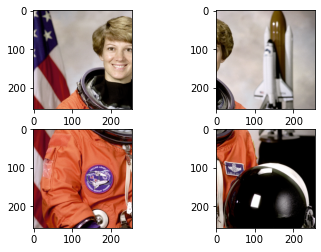

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(tiled_astronaut_images[0])
ax[0,1].imshow(tiled_astronaut_images[1])
ax[1,0].imshow(tiled_astronaut_images[2])
ax[1,1].imshow(tiled_astronaut_images[3])
plt.show()

## Applying your own custom function to images

Next you'll want to do some image processing, and apply a function to your images. <br>

We'll use a very simple example: converting an RGB image to grayscale. But you can also use this method to apply arbittrary functions to dask images. To convert our image to grayscale, we'll use the equation to calculate luminance: <br>

> - Y = 0.2125 R + 0.7154 G + 0.0721 B

We'll write the function for this equation as follows:

In [67]:
def grayscale(rgb):
    result = #TODO
    return result

Let's apply this function to the astronaut image we read in as a single file and visualize the computation graph.

(Visualizing the computation graph isn't necessary most of the time but it's helpful to know what dask is doing under the hood, and it can also be very useful for debugging problems.)

dask.array<add, shape=(1, 512, 512), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>


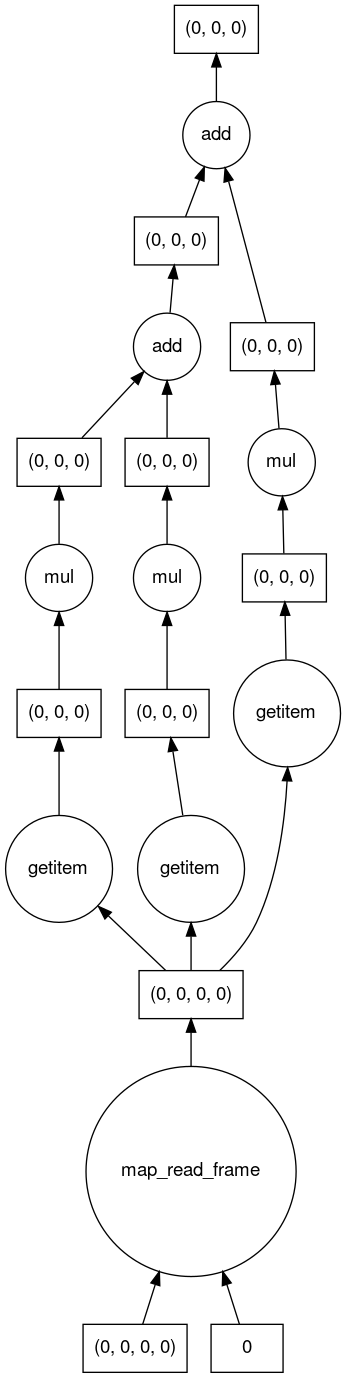

In [68]:
single_image_result = grayscale(astronaut)
print(single_image_result)
single_image_result.visualize()

We also see that there are no longer three color channels in the shape of the result, and that the output image is as expected.

Original image dimensions:  (1, 512, 512, 3)
Processed image dimensions: (1, 512, 512)


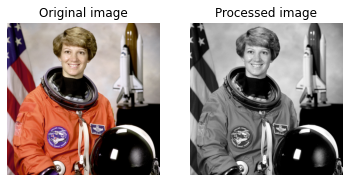

In [69]:
print("Original image dimensions: ", astronaut.shape)
print("Processed image dimensions:", single_image_result.shape)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(astronaut[0, ...])            # display the first (and only) frame of the image
ax1.imshow(single_image_result[0, ...], cmap='gray')  # display the first (and only) frame of the image

# Subplot headings
ax0.set_title('Original image')
ax1.set_title('Processed image')

# Don't display axes
ax0.axis('off')
ax1.axis('off')

# Display images
plt.show(fig)

## Embarrassingly parallel problems

The syntax is identical to apply a function to multiple images or dask chunks. This is an example of an embarrassingly parallel problem, and we see that dask automatically creates a computation graph for each chunk.

dask.array<add, shape=(4, 256, 256), dtype=float32, chunksize=(1, 256, 256), chunktype=numpy.ndarray>


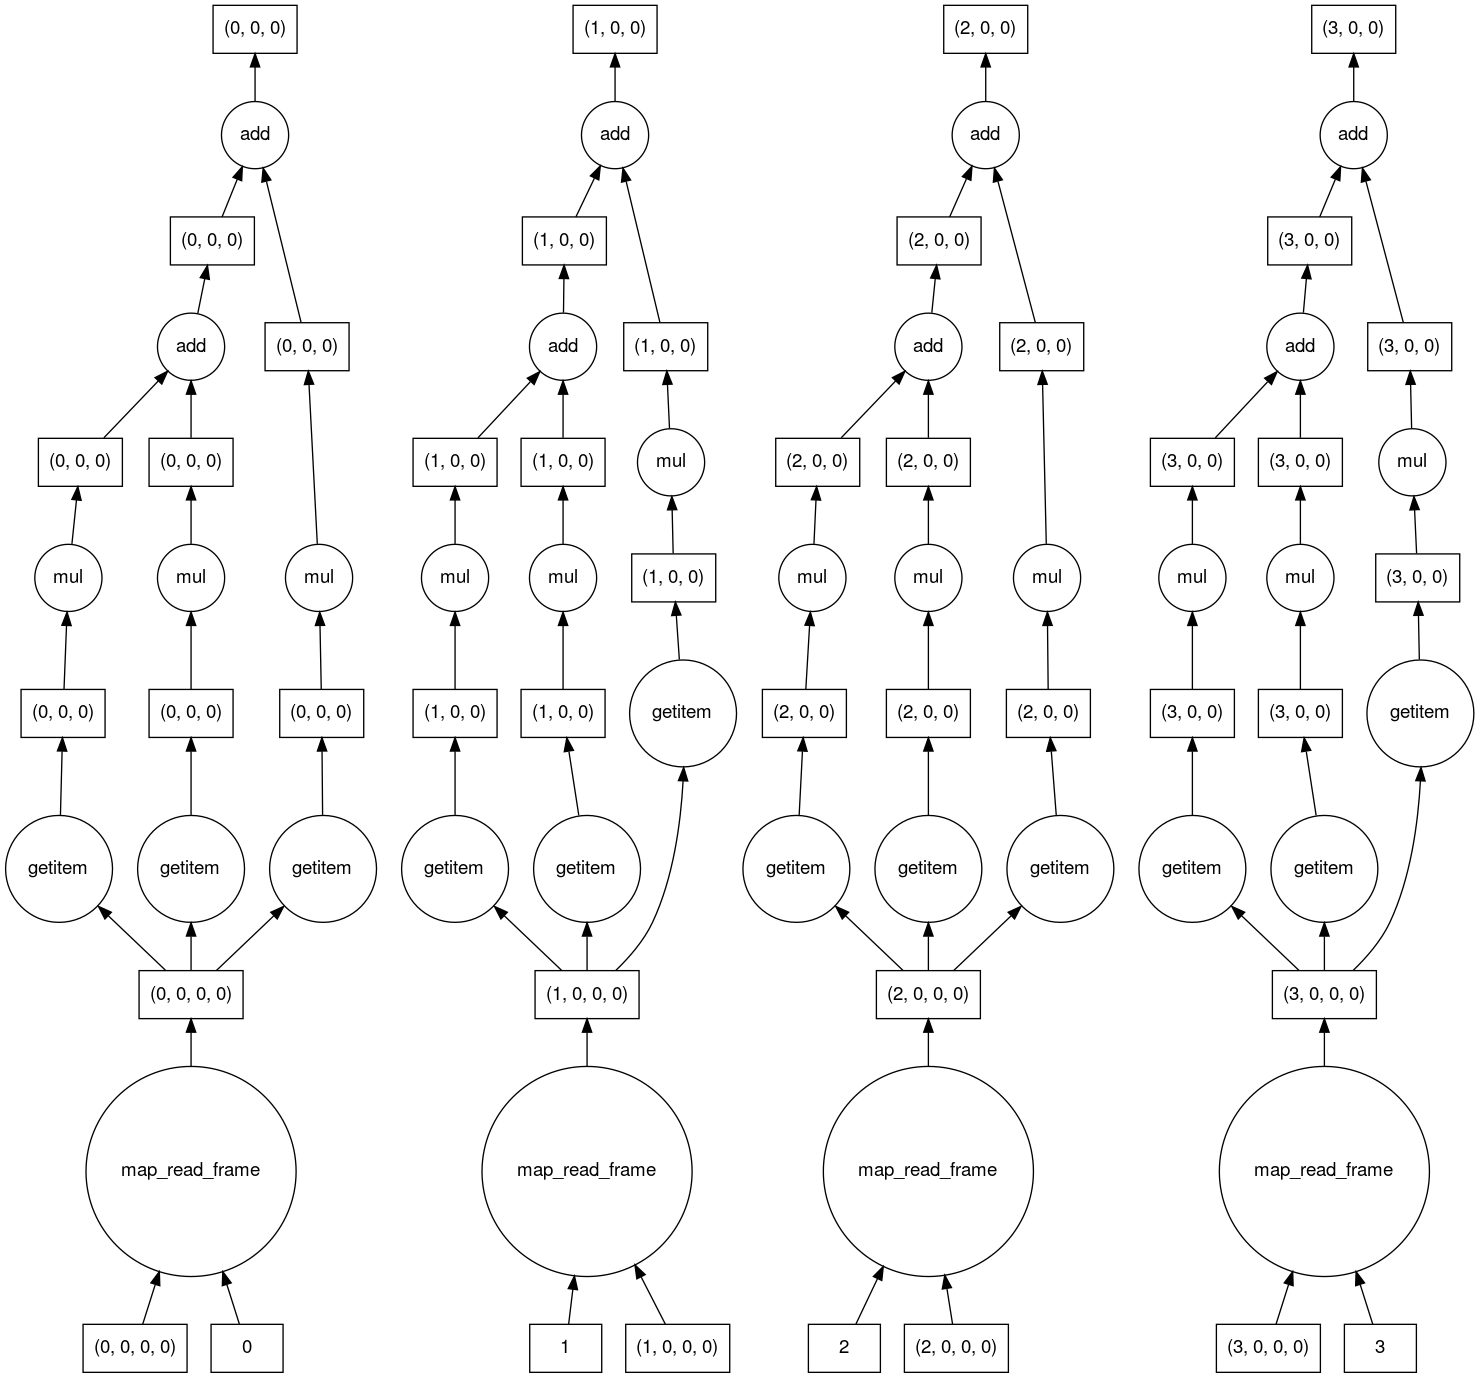

In [70]:
result = ## TODO ON TILEDS ASTRONAUT IMAGES
print(result)
result.visualize()

Let's take a look at the results.

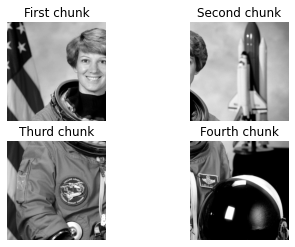

In [71]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
ax0.imshow(result[0, ...], cmap='gray')
ax1.imshow(result[1, ...], cmap='gray')
ax2.imshow(result[2, ...], cmap='gray')
ax3.imshow(result[3, ...], cmap='gray')

# Subplot headings
ax0.set_title('First chunk')
ax1.set_title('Second chunk')
ax2.set_title('Thurd chunk')
ax3.set_title('Fourth chunk')

# Don't display axes
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Display images
plt.show(fig)

## Joining partial images together

OK, Things are looking pretty good! But how can we join these image chunks together?

So far, we haven't needed any information from neighboring pixels to do our calculations. But there are lots of functions (like those in dask-image ndfilters) that do need this for accurate results. You could end up with unwanted edge effects if you don't tell dask how your images should be joined.

Dask has several ways to join chunks together: Stack, Concatenate, and Block.

Block is very versatile, so we'll use that in this next example. You simply pass in a list (or list of lists) to tell dask the spatial relationship between image chunks.

(512, 512)


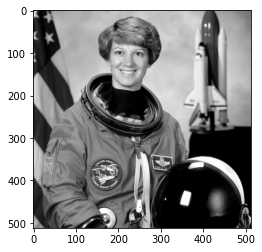

In [72]:
data = [[result[0, ...], result[1, ...]],
        [result[2, ...], result[3, ...]]]
combined_image = ## TODO 
print(combined_image.shape)
plt.imshow(combined_image, cmap='gray')

## A segmentation analysis pipeline

We'll walk through a simple image segmentation and analysis pipeline with three steps:

1. Filtering
2. Segmenting
3. Analyzing

## Filtering
Most analysis pipelines require some degree of image preprocessing. dask-image has a number of inbuilt filters available via dask-image ndfilters.

Commonly a guassian filter may used to smooth the image before segmentation. This causes some loss of sharpness in the image, but can improve segmentation quality for methods that rely on image thresholding.

In [73]:
smoothed_image = ## TODO apply gaussian filter from dask_image.ndfilters with unit variance

We see a small amount of blur in the smoothed image.

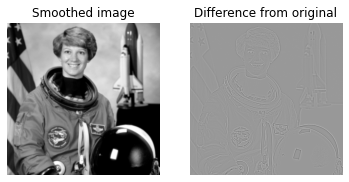

In [74]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(smoothed_image, cmap='gray')
ax1.imshow(smoothed_image - combined_image, cmap='gray')

# Subplot headings
ax0.set_title('Smoothed image')
ax1.set_title('Difference from original')

# Don't display axes
ax0.axis('off')
ax1.axis('off')

# Display images
plt.show(fig)

Since the gaussian filter uses information from neighbouring pixels, the computational graph looks more complicated than the ones we looked at earlier. This is no longer embarrassingly parallel. Where possible dask keeps the computations for each of the four image chunks separate, but must combine information from different chunks near the edges.

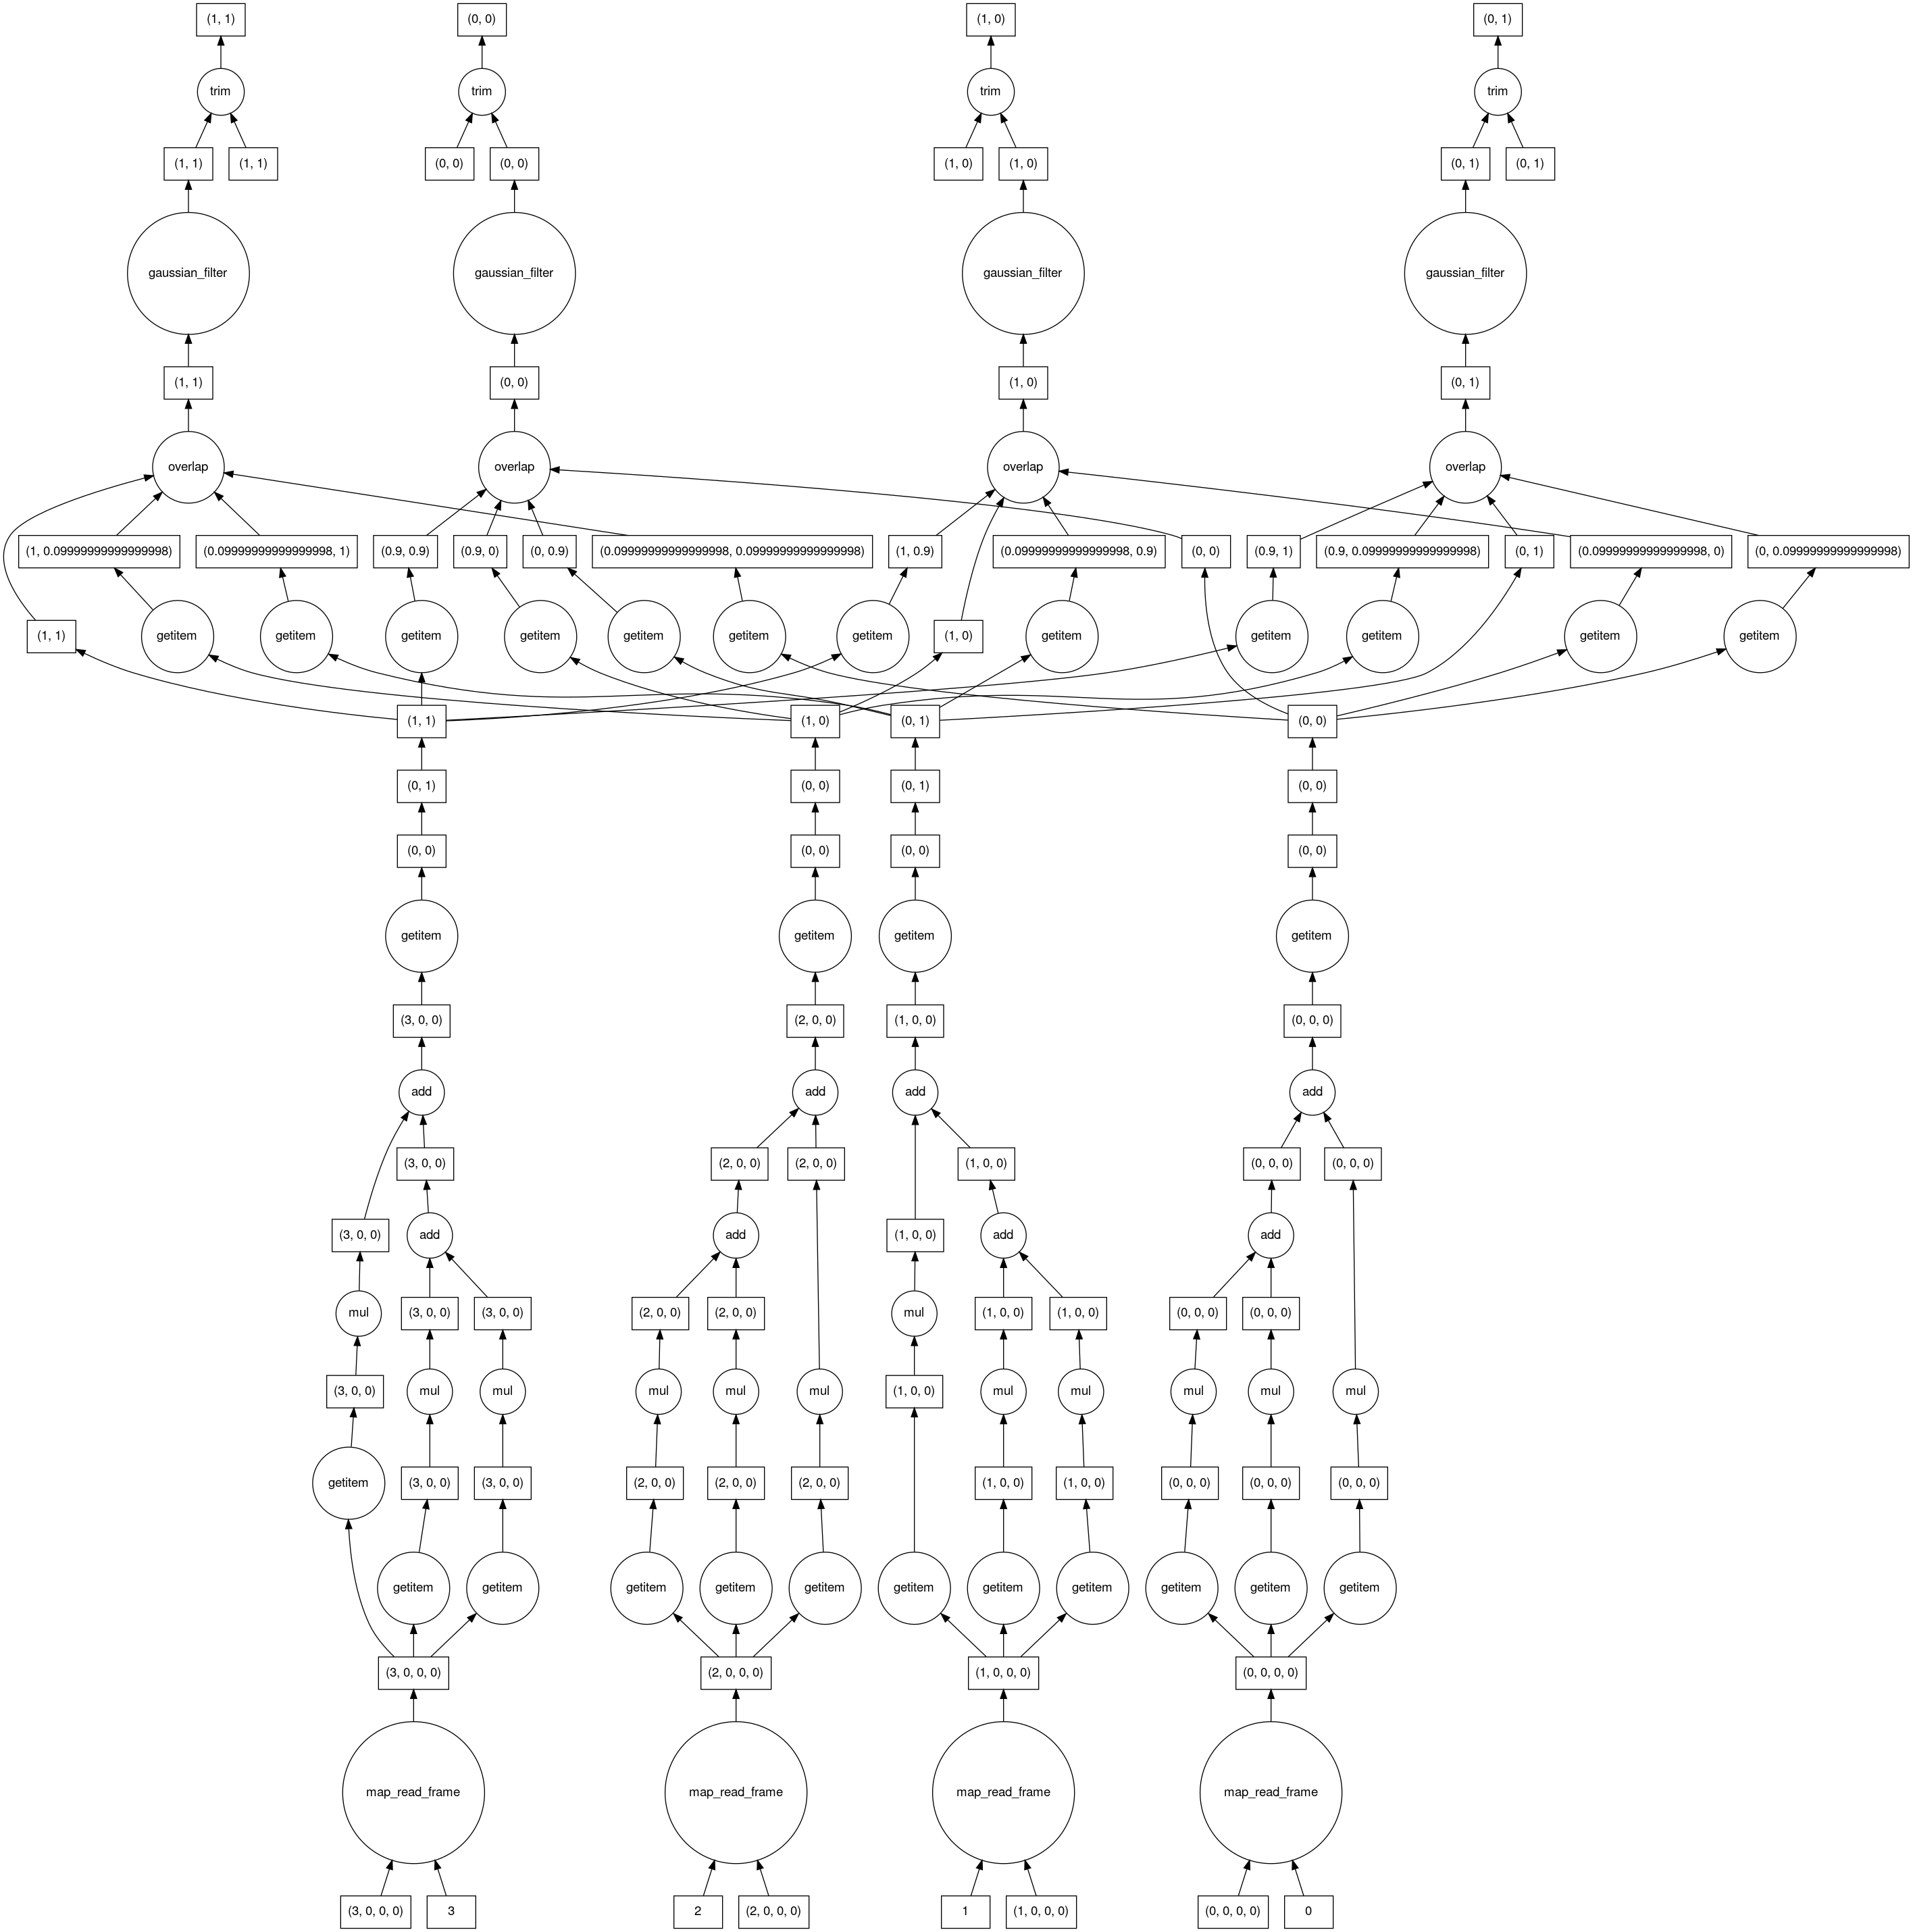

In [75]:
smoothed_image.visualize()

## Segmenting
After the image preprocessing, we segment regions of interest from the data. We'll use a simple arbitrary threshold as the cutoff, at 75% of the maximum intensity of the smoothed image.

In [76]:
threshold_value = 0.75 * da.max(smoothed_image).compute()
print(threshold_value)

0.747274786233902


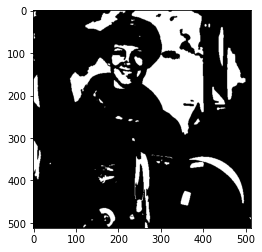

In [77]:
threshold_image = smoothed_image > threshold_value
plt.imshow(threshold_image, cmap='gray')

Next, we label each region of connected pixels above the threshold value. For this we use the label function from dask-image ndmeasure. This will return both the label image, and the number of labels.

In [78]:
label_image, num_labels = ## TODO

Number of labels: 78


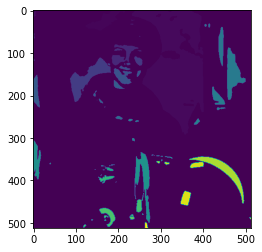

In [79]:
print("Number of labels:", int(num_labels)) # You have to find 78 labels
plt.imshow(label_image, cmap='viridis')

# Reading and manipulating tiled GeoTIFF datasets

This notebook shows how to perform simple calculations with a GeoTIFF dataset using XArray and Dask. We load and rescale a Landsat 8 image and compute NDVI (Normalized difference vegetation index). This can be used to distinguish green vegetation from areas of bare land or water.

We'll use an image of the Denver, USA area taken in July 2018.

![RGB image](https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_thumb_small.jpg)

## Download data

First, we download the dataset. We are using an image from the cloud-hosted [Landsat 8 public dataset](https://landsatonaws.com/) and each band is available as a separate GeoTIFF file.

In [2]:
import os
import json
import rasterio
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nir_filename = 'https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_B5.TIF'
red_filename = 'https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_B4.TIF'
mtl_filename = 'https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_MTL.json'

In [4]:
def download_file(in_filename, out_filename):
    if not os.path.exists(out_filename):
        print("Downloading", in_filename)
        response = requests.get(in_filename)
        with open(out_filename, 'wb') as f:
            f.write(response.content)

In [5]:
download_file(nir_filename, 'nir.tif')
download_file(red_filename, 'red.tif')
download_file(mtl_filename, 'meta.json')

## Check image metadata

Let's see if the image is tiled so we can select a chunk size.

In [6]:
img = rasterio.open('red.tif')
print(img.is_tiled)

True


In [7]:
img.block_shapes

[(512, 512)]

The image has separate blocks for each band with block size 512 x 512. 

## Create XArray datasets

In [10]:
import xarray as xr
red = xr.open_rasterio('red.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
nir = xr.open_rasterio('nir.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
nir

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  This is separate from the ipykernel package so we can avoid doing imports until


<xarray.DataArray (band: 1, y: 7841, x: 7721)>
dask.array<open_rasterio-f37d2225b32864889e9a6dc6cda94c64<this-array>, shape=(1, 7841, 7721), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.423e+06 4.423e+06 4.423e+06 ... 4.188e+06 4.188e+06
  * x        (x) float64 4.134e+05 4.134e+05 4.135e+05 ... 6.45e+05 6.45e+05
Attributes:
    transform:      (30.0, 0.0, 413385.0, 0.0, -30.0, 4423215.0)
    crs:            +init=epsg:32613
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

Each dataset's data is a Dask array.

In [11]:
red.variable.data

dask.array<open_rasterio-d11d711a8b25e8e2e63cae3ff32bbde6<this-array>, shape=(1, 7841, 7721), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

## Optional: create a Dask client

You can start a Dask client to monitor execution with the dashboard.

In [14]:
import dask
from dask.distributed import Client
client = Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.138.0.36:8787/status,
Dashboard: http://10.138.0.36:8787/status,Workers: 1
Total threads: 8,Total memory: 29.45 GiB
Status: running,Using processes: False
Comm: inproc://10.138.0.36/7997/1,Workers: 1
Dashboard: http://10.138.0.36:8787/status,Total threads: 8
Started: Just now,Total memory: 29.45 GiB
Comm: inproc://10.138.0.36/7997/4,Total threads: 8
Dashboard: http://10.138.0.36:39665/status,Memory: 29.45 GiB
Nanny: None,


## Rescale bands using Landsat metadata

The Landsat Level 1 images are delivered in a quantized format. This has to be [converted to top-of-atmosphere reflectance](https://landsat.usgs.gov/using-usgs-landsat-8-product) using the provided metadata.

First we define convenience functions to load the rescaling factors and transform a dataset. The red band is band 4 and near infrared is band 5.

In [15]:
def load_scale_factors(filename, band_number):
    with open(filename) as f:
        metadata = json.load(f)
    M_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_MULT_BAND_{}'.format(band_number)]
    A_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_ADD_BAND_{}'.format(band_number)]
    return M_p, A_p

In [16]:
def calculate_reflectance(ds, band_number, metafile='meta.json'):
    M_p, A_p = load_scale_factors(metafile, band_number)
    toa = M_p * ds + A_p
    return toa

In [17]:
red_toa = ##TODO calculate refletance for red band
nir_toa = ##TODO calculate refletance for nir band

Because the transformation is composed of arithmetic operations, execution is delayed and the operations are parallelized automatically.

In [18]:
print(red_toa.variable.data)

dask.array<add, shape=(1, 7841, 7721), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>


The resulting image has floating point data with magnitudes appropriate to reflectance. This can be checked by computing the range of values in an image:

In [19]:
red_max, red_min, red_mean = dask.compute(
    red_toa.max(dim=['x', 'y']), 
    red_toa.min(dim=['x', 'y']),
    red_toa.mean(dim=['x', 'y'])
)
print(red_max.item())
print(red_min.item())
print(red_mean.item())

1.2107
-0.1
0.05921340355007137


## Calculate and display NDVI

Now that we have the image as reflectance values, we are ready to compute NDVI.

$$
NDVI = \frac{NIR - Red}{NIR + Red}
$$

This highlights areas of healthy vegetation with high NDVI values, which appear as green in the image below.

In [20]:
ndvi = ## TODO Compute NDVI

In [21]:
ndvi2d = ## Remove one dimension of ndvi (tensor) for 2D plotting

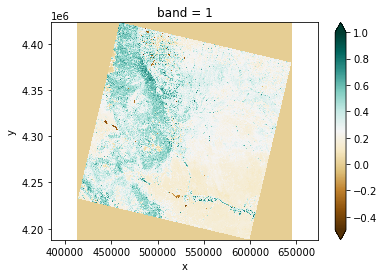

In [22]:
plt.figure()
im = ndvi2d.compute().plot.imshow(cmap='BrBG', vmin=-0.5, vmax=1)
plt.axis('equal')
plt.show()

## Tracking the International Space Station with Dask

We will use two APIs: Google Maps Geocoder & Open Notify API for ISS location. <br>
We will use them to track ISS location and next transit time with respect to a list of cities. To create our charts and parallelise data intelligently, we will use Dask, specifically Dask Delayed.

In [24]:
import requests
import logging
import sys
import numpy as np
from time import sleep
from datetime import datetime
from math import radians
from dask import delayed
from operator import itemgetter
from sklearn.neighbors import DistanceMetric

### Latitude and longitude pairs from a list of cities

In [26]:
def get_lat_long(address):
    resp = requests.get(
        'https://eu1.locationiq.org/v1/search.php',
        params={'key': '92e7ba84cf3465',
                'q': address,
                'format': 'json'}
    )
    if resp.status_code != 200:
        print('There was a problem with your request!')
        print(resp.content)
        return
    data = resp.json()[0]
    return {
        'name': data.get('display_name'),
        'lat': float(data.get('lat')),
        'long': float(data.get('lon')),
    }

In [27]:
get_lat_long('Berlin, Germany')

{'name': 'Berlin, Germany', 'lat': 52.5170365, 'long': 13.3888599}

In [28]:
locations = []
for city in ['Seattle, Washington',
             'Miami, Florida',
             'Berlin, Germany',
             'Singapore',
             'Wellington, New Zealand',
             'Beirut, Lebanon',
             'Beijing, China',
             'Nairobi, Kenya',
             'Cape Town, South Africa',
             'Buenos Aires, Argentina']:
    locations.append(get_lat_long(city))
    sleep(2)

In [29]:
locations

[{'name': 'Seattle, King County, Washington, USA',
  'lat': 47.6038321,
  'long': -122.3300624},
 {'name': 'Miami, Miami-Dade County, Florida, USA',
  'lat': 25.7741728,
  'long': -80.19362},
 {'name': 'Berlin, Germany', 'lat': 52.5170365, 'long': 13.3888599},
 {'name': 'Singapore', 'lat': 1.357107, 'long': 103.8194992},
 {'name': 'Wellington, Wellington City, Wellington, 6011, New Zealand',
  'lat': -41.2887953,
  'long': 174.7772114},
 {'name': 'Beirut, Beirut Governorate, Lebanon',
  'lat': 33.8959203,
  'long': 35.47843},
 {'name': 'Beijing, Dongcheng District, Beijing, 100010, China',
  'lat': 39.906217,
  'long': 116.3912757},
 {'name': 'Nairobi, Kenya', 'lat': -1.2832533, 'long': 36.8172449},
 {'name': 'Cape Town, City of Cape Town, Western Cape, 8001, South Africa',
  'lat': -33.928992,
  'long': 18.417396},
 {'name': 'Buenos Aires, Comuna 6, Autonomous City of Buenos Aires, Argentina',
  'lat': -34.6075682,
  'long': -58.4370894}]

### Retrieve ISS data and determine transit times of cities

In [30]:
def get_spaceship_location():
    resp = requests.get('http://api.open-notify.org/iss-now.json')
    location = resp.json()['iss_position']
    return {'lat': float(location.get('latitude')),
            'long': float(location.get('longitude'))}

In [31]:
def great_circle_dist(lon1, lat1, lon2, lat2):
    dist = DistanceMetric.get_metric('haversine')
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    X = [[lat1, lon1], [lat2, lon2]]
    kms = 6367
    return (kms * dist.pairwise(X)).max()

In [32]:
def iss_dist_from_loc(issloc, loc):
    distance = great_circle_dist(issloc.get('long'),
                                 issloc.get('lat'),
                                 loc.get('long'), loc.get('lat'))
    logging.info('ISS is ~%dkm from %s', int(distance), loc.get('name'))
    return distance

In [33]:
def iss_pass_near_loc(loc):
    resp = requests.get('http://api.open-notify.org/iss-pass.json',
                        params={'lat': loc.get('lat'),
                                'lon': loc.get('long')})
    data = resp.json().get('response')[0]
    td = datetime.fromtimestamp(data.get('risetime')) - datetime.now()
    m, s = divmod(int(td.total_seconds()), 60)
    h, m = divmod(m, 60)
    logging.info('ISS will pass near %s in %02d:%02d:%02d',loc.get('name'), h, m, s)
    return td.total_seconds()

In [34]:
iss_dist_from_loc(get_spaceship_location(), locations[2])

7597.670519583981

In [35]:
iss_pass_near_loc(locations[2])

934.261661

### Creating a delayed pipeline

In [36]:
## TODO find the closest city
## hint: loop on locations -> compute get_spaceship_location and the iss_dist_from_loc
## To transform a function into a dask delayed function, use delayed. For instance, delayed(get_spaceship_location)()
## Don't forget the compute() to get a value and find the closest city